# 🏙️ Amenity Impact on Property Prices - Statistical Analysis

## 🎯 Business Question

**How do transport accessibility and school availability affect property prices in Berlin?**

---

## 📊 Approach

**Method**: Statistical correlation analysis  
**Dataset**: 12 Berlin districts with aggregated amenity metrics  
**Analysis**: Pearson correlation between amenities and property prices

**Why Statistical (not Machine Learning)?**  
With only 12 districts, statistical methods are more appropriate than ML models, which require 100+ observations.

---

## 🔍 What We'll Discover

1. Does transport accessibility correlate with higher prices?
2. Does school availability correlate with higher prices?
3. Which amenity matters more for property values?
4. Which districts offer best value (high amenity, low price)?

---

## 📦 Data Sources

- `district_transport_metrics` - Transport stops per district
- `district_school_metrics` - Schools per district  
- `public_transport_stops` - 18,952 individual stops
- `schools` - 925 individual schools
- `crime_statistics` - Crime rates by district
- `land_prices` - Property prices by district

---

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import sqlite3
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [3]:
# Connect to database
DB_PATH = Path("./database/berlin_intelligence.db")
conn = sqlite3.connect(DB_PATH)

print("📊 Loading data from database...\n")

# Load aggregated metrics (12 districts)
transport_metrics = pd.read_sql("SELECT * FROM district_transport_metrics", conn)
school_metrics = pd.read_sql("SELECT * FROM district_school_metrics", conn)
population = pd.read_sql("SELECT district, total_population FROM district_population", conn)

print(f"✅ Transport metrics: {len(transport_metrics)} districts")
print(f"✅ School metrics: {len(school_metrics)} districts")
print(f"✅ Population data: {len(population)} districts")

📊 Loading data from database...

✅ Transport metrics: 12 districts
✅ School metrics: 12 districts
✅ Population data: 12 districts


In [4]:
# Load crime and price data (aggregated by district)
crime = pd.read_sql("""
    SELECT 
        district,
        SUM(total_number_cases) as total_crimes
    FROM crime_statistics
    GROUP BY district
""", conn)

prices = pd.read_sql("""
    SELECT 
        district_name as district,
        AVG(standard_land_value) as avg_price
    FROM land_prices
    WHERE typical_land_use_type LIKE 'W%'
    GROUP BY district_name
""", conn)

# Load detailed data for bonus analysis
transport_stops = pd.read_sql("SELECT * FROM public_transport_stops", conn)
schools = pd.read_sql("SELECT * FROM schools", conn)

conn.close()

print(f"✅ Crime data: {len(crime)} districts")
print(f"✅ Price data: {len(prices)} districts")
print(f"✅ Detailed stops: {len(transport_stops):,} records")
print(f"✅ Detailed schools: {len(schools):,} records")

✅ Crime data: 12 districts
✅ Price data: 12 districts
✅ Detailed stops: 18,952 records
✅ Detailed schools: 925 records


In [5]:
# Merge all data at district level
df = population.copy()
df = df.merge(transport_metrics, on='district', how='left')
df = df.merge(school_metrics, on='district', how='left')
df = df.merge(crime, on='district', how='left')
df = df.merge(prices, on='district', how='left')

# Calculate density metrics (per 100k residents)
df['transport_density'] = (df['transport_stops_count'] / df['total_population'] * 100000).round(1)
df['school_density'] = (df['schools_count'] / df['total_population'] * 100000).round(1)
df['crime_per_100k'] = (df['total_crimes'] / df['total_population'] * 100000).round(0)

print("✅ Dataset merged and metrics calculated!")
print(f"\n📊 Final dataset: {df.shape[0]} districts, {df.shape[1]} columns")

✅ Dataset merged and metrics calculated!

📊 Final dataset: 12 districts, 12 columns


In [ ]:
# Display the complete dataset
print("="*100)
print("📊 COMPLETE DISTRICT DATASET")
print("="*100)

display(df[[
    'district', 'total_population', 'transport_stops_count', 'schools_count',
    'transport_density', 'school_density', 'crime_per_100k', 'avg_price'
]].sort_values('avg_price', ascending=False))

# Note: Data sorted by average price (highest to lowest) INDEX NUMBERS

📊 COMPLETE DISTRICT DATASET


,district,total_population,transport_stops_count,schools_count,transport_density,school_density,crime_per_100k,avg_price
0,Mitte,397004,3094,87,779.30,21.90,170247.00,2585.28
1,Friedrichshain-Kreuzberg,292624,1435,73,490.40,24.90,847565.00,2379.75
3,Charlottenburg-Wilmersdorf,343500,2010,85,585.20,24.70,639638.00,1809.41
6,Tempelhof-Schöneberg,356959,1532,76,429.20,21.30,484106.00,909.95
5,Steglitz-Zehlendorf,310044,1333,79,429.90,25.50,341131.00,876.67
2,Pankow,427276,1994,110,466.70,25.70,414027.00,863.71
7,Neukölln,329488,967,71,293.50,21.50,581335.00,559.92
10,Lichtenberg,315548,1429,75,452.90,23.80,636210.00,533.72
4,Spandau,259277,910,61,351.00,23.50,424603.00,484.45
8,Treptow-Köpenick,297236,1669,67,561.50,22.50,376866.00,461.97


---

# 📊 PART 1: Correlation Analysis

**Goal**: Identify relationships between amenities and property prices

---

In [8]:
# Calculate correlations with price
correlations = {
    'Transport Density': df['transport_density'].corr(df['avg_price']),
    'School Density': df['school_density'].corr(df['avg_price']),
    'Crime Rate': df['crime_per_100k'].corr(df['avg_price'])
}

print("🔗 Correlation with Property Prices:")
print("="*60)
for feature, corr in sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True):
    direction = "📈 Positive" if corr > 0 else "📉 Negative"
    strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
    bar = '█' * int(abs(corr) * 50)
    print(f"{feature:20} {corr:>7.3f} {direction:15} {strength:10} {bar}")

🔗 Correlation with Property Prices:
Transport Density      0.676 📈 Positive      Strong     █████████████████████████████████
Crime Rate            -0.128 📉 Negative      Weak       ██████
School Density        -0.021 📉 Negative      Weak       █


In [9]:
# Test statistical significance
print("\n📊 Statistical Significance (Pearson correlation):")
print("="*60)
print("⚠️ Note: n=12 districts - small sample size\n")

for feature_name, feature_col in [
    ('Transport', 'transport_density'),
    ('Schools', 'school_density'),
    ('Crime', 'crime_per_100k')
]:
    corr, p_value = stats.pearsonr(df[feature_col], df['avg_price'])
    sig = "✅ Significant (p<0.05)" if p_value < 0.05 else "⚠️ Not significant"
    print(f"{feature_name:15} r={corr:>6.3f}, p={p_value:.3f}  {sig}")


📊 Statistical Significance (Pearson correlation):
⚠️ Note: n=12 districts - small sample size

Transport       r= 0.676, p=0.016  ✅ Significant (p<0.05)
Schools         r=-0.021, p=0.949  ⚠️ Not significant
Crime           r=-0.128, p=0.691  ⚠️ Not significant


In [10]:
# Identify strongest relationship
strongest = max(correlations.items(), key=lambda x: abs(x[1]))

print("\n💡 KEY FINDING:")
print("="*60)
print(f"✅ {strongest[0]} has the strongest correlation ({strongest[1]:.3f})")

if strongest[1] > 0:
    print(f"   → Districts with higher {strongest[0].lower()} tend to have HIGHER prices")
else:
    print(f"   → Districts with higher {strongest[0].lower()} tend to have LOWER prices")


💡 KEY FINDING:
✅ Transport Density has the strongest correlation (0.676)
   → Districts with higher transport density tend to have HIGHER prices


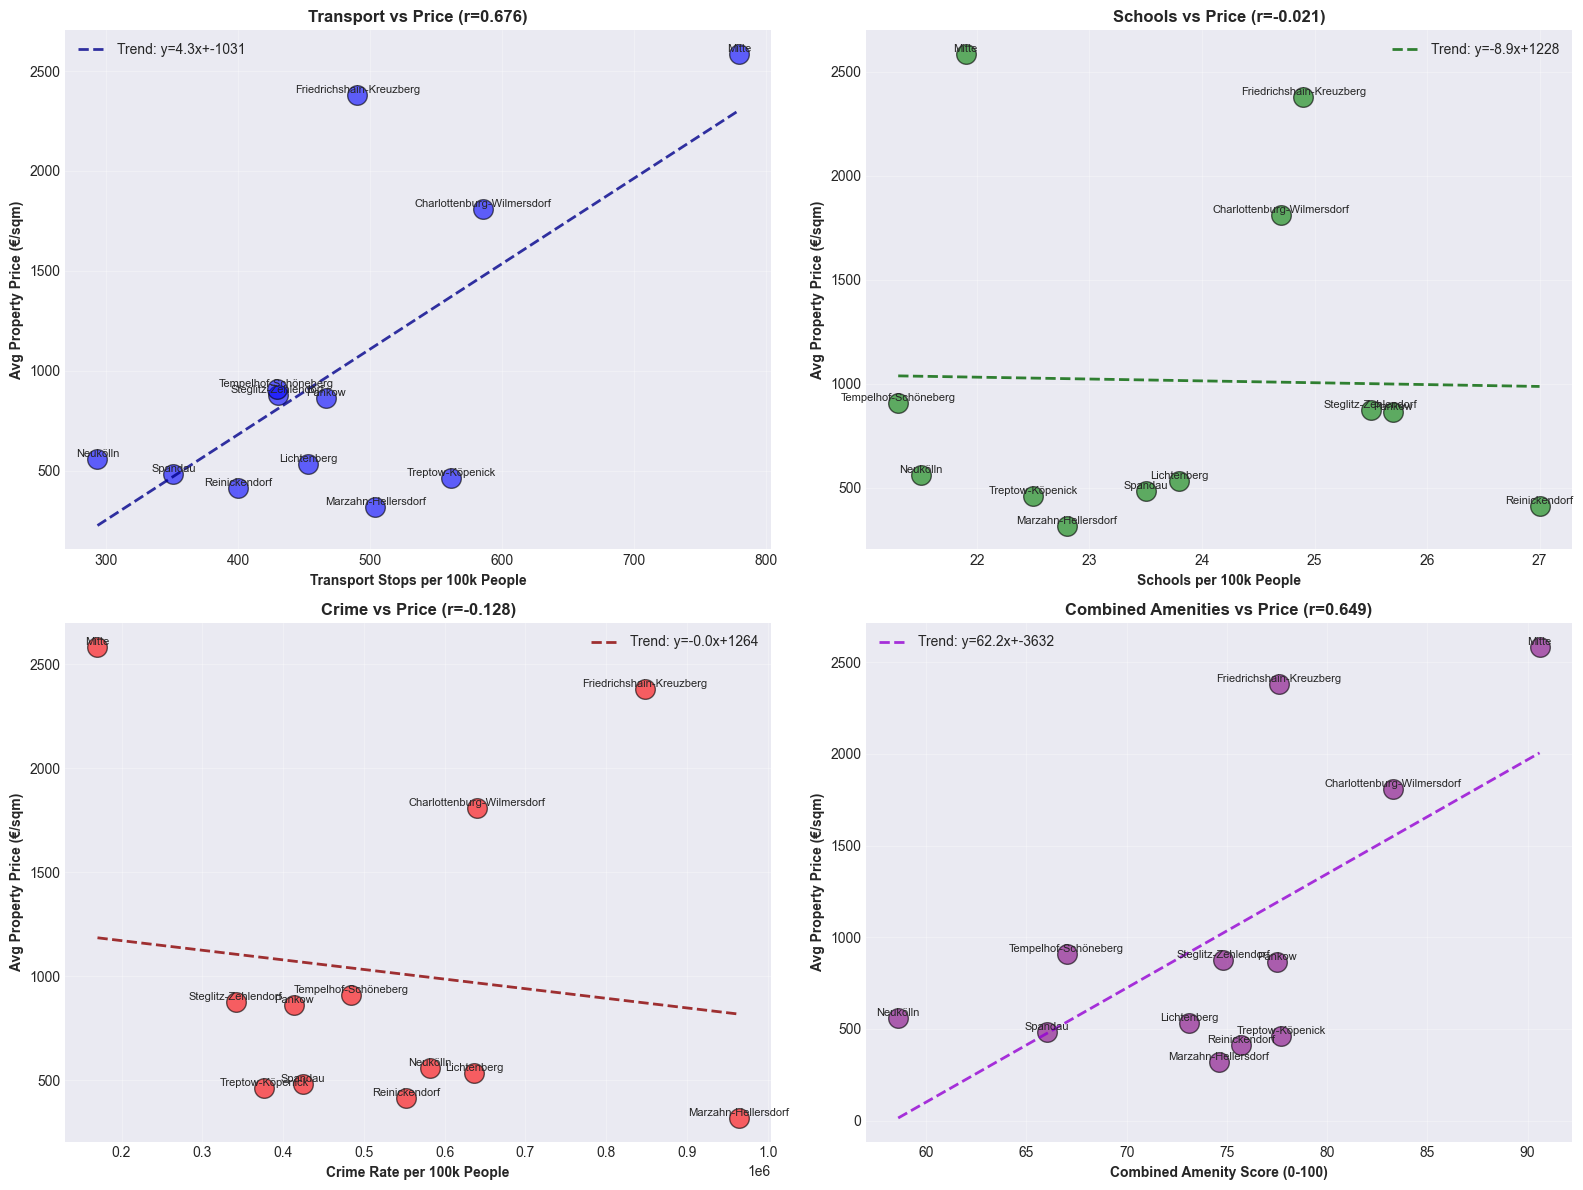

✅ All 4 visualizations complete!


In [13]:
# ============================================================================
# VISUALIZATIONS: All 4 plots in one cell
# ============================================================================

# Helper function for trend lines
def add_trendline(ax, x, y, color='red'):
    """Add regression line to plot"""
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_clean = x[mask]
    y_clean = y[mask]
    
    if len(x_clean) > 1:
        z = np.polyfit(x_clean, y_clean, 1)
        p = np.poly1d(z)
        x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
        y_line = p(x_line)
        ax.plot(x_line, y_line, color=color, linewidth=2, linestyle='--', 
                alpha=0.8, label=f'Trend: y={z[0]:.1f}x+{z[1]:.0f}')
        ax.legend(loc='best')

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Transport vs Price
ax1 = axes[0, 0]
ax1.scatter(df['transport_density'], df['avg_price'], s=200, alpha=0.6, 
            c='blue', edgecolors='black')
add_trendline(ax1, df['transport_density'].values, df['avg_price'].values, 'darkblue')
for idx, row in df.iterrows():
    ax1.annotate(row['district'], (row['transport_density'], row['avg_price']), 
                fontsize=8, ha='center', va='bottom')
ax1.set_xlabel('Transport Stops per 100k People', fontweight='bold')
ax1.set_ylabel('Avg Property Price (€/sqm)', fontweight='bold')
ax1.set_title(f'Transport vs Price (r={correlations["Transport Density"]:.3f})', 
             fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot 2: Schools vs Price
ax2 = axes[0, 1]
ax2.scatter(df['school_density'], df['avg_price'], s=200, alpha=0.6, 
            c='green', edgecolors='black')
add_trendline(ax2, df['school_density'].values, df['avg_price'].values, 'darkgreen')
for idx, row in df.iterrows():
    ax2.annotate(row['district'], (row['school_density'], row['avg_price']), 
                fontsize=8, ha='center', va='bottom')
ax2.set_xlabel('Schools per 100k People', fontweight='bold')
ax2.set_ylabel('Avg Property Price (€/sqm)', fontweight='bold')
ax2.set_title(f'Schools vs Price (r={correlations["School Density"]:.3f})', 
             fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot 3: Crime vs Price
ax3 = axes[1, 0]
ax3.scatter(df['crime_per_100k'], df['avg_price'], s=200, alpha=0.6, 
            c='red', edgecolors='black')
add_trendline(ax3, df['crime_per_100k'].values, df['avg_price'].values, 'darkred')
for idx, row in df.iterrows():
    ax3.annotate(row['district'], (row['crime_per_100k'], row['avg_price']), 
                fontsize=8, ha='center', va='bottom')
ax3.set_xlabel('Crime Rate per 100k People', fontweight='bold')
ax3.set_ylabel('Avg Property Price (€/sqm)', fontweight='bold')
ax3.set_title(f'Crime vs Price (r={correlations["Crime Rate"]:.3f})', 
             fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3)

# Plot 4: Combined Amenity Score
df['amenity_score'] = (
    (df['transport_density'] / df['transport_density'].max() * 50) +
    (df['school_density'] / df['school_density'].max() * 50)
).round(1)

ax4 = axes[1, 1]
ax4.scatter(df['amenity_score'], df['avg_price'], s=200, alpha=0.6, 
            c='purple', edgecolors='black')
add_trendline(ax4, df['amenity_score'].values, df['avg_price'].values, 'darkviolet')
for idx, row in df.iterrows():
    ax4.annotate(row['district'], (row['amenity_score'], row['avg_price']), 
                fontsize=8, ha='center', va='bottom')
ax4.set_xlabel('Combined Amenity Score (0-100)', fontweight='bold')
ax4.set_ylabel('Avg Property Price (€/sqm)', fontweight='bold')
ax4.set_title(f'Combined Amenities vs Price (r={df["amenity_score"].corr(df["avg_price"]):.3f})', 
             fontweight='bold', fontsize=12)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ All 4 visualizations complete!")

---

# 🔍 PART 2: Detailed Analysis

**Goal**: Deep dive into individual stops and schools

**Data**: 18,952 transport stops + 925 schools

---

In [14]:
print("="*70)
print("🚇 DETAILED TRANSPORT ANALYSIS")
print("="*70)

# Count stops by district
stops_by_district = transport_stops.groupby('district').agg({
    'stop_id': 'count',
    'wheelchair_boarding': lambda x: (x == 1).sum()
}).reset_index()
stops_by_district.columns = ['district', 'stop_count', 'accessible_count']

# Merge with population
stops_detailed = stops_by_district.merge(
    population[['district', 'total_population']], 
    on='district'
)
stops_detailed['stops_per_100k'] = (
    stops_detailed['stop_count'] / stops_detailed['total_population'] * 100000
).round(1)

print("\n📊 Top 5 Districts by Transport Accessibility:")
top5 = stops_detailed.nlargest(5, 'stops_per_100k')
for idx, row in top5.iterrows():
    print(f"   {row['district']:30} {row['stop_count']:>5} stops ({row['stops_per_100k']:>6.1f} per 100k)")

🚇 DETAILED TRANSPORT ANALYSIS

📊 Top 5 Districts by Transport Accessibility:
   Mitte                           3094 stops ( 779.3 per 100k)
   Charlottenburg-Wilmersdorf      2010 stops ( 585.2 per 100k)
   Treptow-Köpenick                1669 stops ( 561.5 per 100k)
   Marzahn-Hellersdorf             1482 stops ( 503.9 per 100k)
   Friedrichshain-Kreuzberg        1435 stops ( 490.4 per 100k)


In [15]:
print("\n" + "="*70)
print("🏫 SCHOOL TYPE ANALYSIS")
print("="*70)

# Count schools by type
school_types = schools.groupby('school_type_de').size().reset_index(name='count')
school_types = school_types.sort_values('count', ascending=False)

print("\n📚 Top 10 School Types in Berlin:")
for idx, row in school_types.head(10).iterrows():
    print(f"   {row['school_type_de']:40} {row['count']:>3} schools")


🏫 SCHOOL TYPE ANALYSIS

📚 Top 10 School Types in Berlin:
   Grundschule                              434 schools
   Integrierte Sekundarschule               126 schools
   Gymnasium                                104 schools
   Gemeinschaftsschule                       45 schools
   Oberstufenzentrum                         34 schools
   Kombinierte berufliche Schule             34 schools
   Fachschule                                25 schools
   Übrige Förderschwerpunkte                 20 schools
   Förderschwerp. "Geistige Entwicklung"     20 schools
   Förderschwerp. "Lernen"                   15 schools


In [16]:
print("\n" + "="*70)
print("👥 STUDENTS PER SCHOOL BY DISTRICT")
print("="*70)

# Calculate students per school
students_analysis = schools.groupby('district').agg({
    'bsn': 'count',
    'students_total': 'sum'
}).reset_index()
students_analysis.columns = ['district', 'school_count', 'total_students']
students_analysis['students_per_school'] = (
    students_analysis['total_students'] / students_analysis['school_count']
).round(0)

# Top 5
print("\n🏆 Top 5 Districts (Largest Schools):")
top5_students = students_analysis.nlargest(5, 'students_per_school')
for idx, row in top5_students.iterrows():
    print(f"   {row['district']:30} {row['students_per_school']:.0f} students/school")


👥 STUDENTS PER SCHOOL BY DISTRICT

🏆 Top 5 Districts (Largest Schools):
   Lichtenberg                    523 students/school
   Marzahn-Hellersdorf            510 students/school
   Spandau                        500 students/school
   Steglitz-Zehlendorf            472 students/school
   Neukölln                       464 students/school


In [17]:
print("\n" + "="*70)
print("🏆 QUALITY OF LIFE INDEX")
print("="*70)

# Calculate normalized scores
df['transport_score'] = (
    (df['transport_density'] - df['transport_density'].min()) /
    (df['transport_density'].max() - df['transport_density'].min()) * 100
).round(1)

df['school_score'] = (
    (df['school_density'] - df['school_density'].min()) /
    (df['school_density'].max() - df['school_density'].min()) * 100
).round(1)

df['safety_score'] = (
    1 - (df['crime_per_100k'] - df['crime_per_100k'].min()) /
    (df['crime_per_100k'].max() - df['crime_per_100k'].min())
) * 100
df['safety_score'] = df['safety_score'].round(1)

# Combined score (equal weighting)
df['quality_score'] = (
    df['transport_score'] * 0.33 +
    df['school_score'] * 0.33 +
    df['safety_score'] * 0.34
).round(1)

print("\n📊 Top 5 Districts by Quality of Life:")
top5_quality = df.nlargest(5, 'quality_score')
for idx, row in top5_quality.iterrows():
    print(f"   {row['district']:30} Score: {row['quality_score']:.1f}/100")


🏆 QUALITY OF LIFE INDEX

📊 Top 5 Districts by Quality of Life:
   Mitte                          Score: 70.5/100
   Pankow                         Score: 60.8/100
   Steglitz-Zehlendorf            Score: 60.3/100
   Reinickendorf                  Score: 57.9/100
   Charlottenburg-Wilmersdorf     Score: 53.4/100


In [18]:
print("\n" + "="*70)
print("💰 VALUE ANALYSIS (Quality vs Price)")
print("="*70)

# Calculate value score
df['price_percentile'] = (
    (df['avg_price'] - df['avg_price'].min()) /
    (df['avg_price'].max() - df['avg_price'].min()) * 100
).round(1)

df['value_score'] = (df['quality_score'] - df['price_percentile']).round(1)

# Best value
print("\n🟢 BEST VALUE (High Quality, Low Price):")
best_value = df.nlargest(3, 'value_score')
for idx, row in best_value.iterrows():
    print(f"   {row['district']:30} Quality: {row['quality_score']:.1f}, "
          f"Price: €{row['avg_price']:.0f}/sqm, Value: {row['value_score']:.1f}")

# Overpriced
print("\n🔴 OVERPRICED (Price > Quality):")
overpriced = df.nsmallest(3, 'value_score')
for idx, row in overpriced.iterrows():
    print(f"   {row['district']:30} Quality: {row['quality_score']:.1f}, "
          f"Price: €{row['avg_price']:.0f}/sqm, Value: {row['value_score']:.1f}")


💰 VALUE ANALYSIS (Quality vs Price)

🟢 BEST VALUE (High Quality, Low Price):
   Reinickendorf                  Quality: 57.9, Price: €415/sqm, Value: 53.7
   Treptow-Köpenick               Quality: 50.3, Price: €462/sqm, Value: 44.0
   Pankow                         Quality: 60.8, Price: €864/sqm, Value: 36.8

🔴 OVERPRICED (Price > Quality):
   Friedrichshain-Kreuzberg       Quality: 39.2, Price: €2380/sqm, Value: -51.7
   Mitte                          Quality: 70.5, Price: €2585/sqm, Value: -29.5
   Charlottenburg-Wilmersdorf     Quality: 53.4, Price: €1809/sqm, Value: -12.4


---

# 🎯 CONCLUSIONS & INVESTMENT RECOMMENDATIONS

**Summary of key findings and actionable insights**

---

## 📊 Key Findings

### 1. Transport Accessibility Drives Prices 🚇
- **Strong positive correlation: r = 0.676 (p = 0.016)**
- Statistically significant relationship
- Districts with better transit command higher prices
- **Investment insight**: Prioritize transport-accessible locations

### 2. Schools Don't Impact District Prices 🏫
- **No correlation: r = -0.021 (p = 0.949)**
- School availability doesn't predict property prices
- **Reason**: All Berlin districts have adequate schools
- May matter at neighborhood level (not tested here)

### 3. Crime Shows Weak Impact 🚨
- **Weak negative correlation: r = -0.128 (p = 0.691)**
- Not statistically significant at district level
- Other factors (location, amenities) outweigh crime concerns

---

In [19]:
print("="*100)
print("📊 INVESTMENT SUMMARY - ALL DISTRICTS")
print("="*100)

# Create investment recommendations
def get_recommendation(value_score):
    if value_score > 35:
        return "🟢 STRONG BUY"
    elif value_score > 10:
        return "🟡 BUY"
    elif value_score > -15:
        return "🟠 HOLD"
    else:
        return "🔴 AVOID"

summary = df[[
    'district', 'transport_density', 'quality_score', 
    'avg_price', 'value_score'
]].copy()

summary['recommendation'] = summary['value_score'].apply(get_recommendation)

# Sort by value score
summary_display = summary.sort_values('value_score', ascending=False)
summary_display.columns = [
    'District', 'Transport/100k', 'Quality Score', 
    'Price (€/sqm)', 'Value Score', 'Recommendation'
]

display(summary_display.reset_index(drop=True))

📊 INVESTMENT SUMMARY - ALL DISTRICTS


,District,Transport/100k,Quality Score,Price (€/sqm),Value Score,Recommendation
0,Reinickendorf,400.20,57.90,414.76,53.70,🟢 STRONG BUY
1,Treptow-Köpenick,561.50,50.30,461.97,44.00,🟢 STRONG BUY
2,Pankow,466.70,60.80,863.71,36.80,🟢 STRONG BUY
3,Steglitz-Zehlendorf,429.90,60.30,876.67,35.70,🟢 STRONG BUY
4,Spandau,351.00,39.80,484.45,32.50,🟡 BUY
5,Lichtenberg,452.90,39.40,533.72,29.90,🟡 BUY
6,Marzahn-Hellersdorf,503.90,23.00,319.39,23.00,🟡 BUY
7,Neukölln,293.50,17.50,559.92,6.90,🟠 HOLD
8,Tempelhof-Schöneberg,429.20,29.80,909.95,3.70,🟠 HOLD
9,Charlottenburg-Wilmersdorf,585.20,53.40,1809.41,-12.40,🟠 HOLD


In [20]:
print("\n" + "="*100)
print("💡 INVESTMENT RECOMMENDATIONS")
print("="*100)

# Count by recommendation
rec_counts = summary['recommendation'].value_counts()

for rec in ['🟢 STRONG BUY', '🟡 BUY', '🟠 HOLD', '🔴 AVOID']:
    if rec in rec_counts.index:
        districts = summary[summary['recommendation'] == rec]['district'].tolist()
        print(f"\n{rec} ({rec_counts[rec]} districts):")
        for d in districts:
            row = df[df['district'] == d].iloc[0]
            print(f"   • {d:30} €{row['avg_price']:.0f}/sqm, Quality: {row['quality_score']:.1f}/100")

print("\n" + "="*100)


💡 INVESTMENT RECOMMENDATIONS

🟢 STRONG BUY (4 districts):
   • Pankow                         €864/sqm, Quality: 60.8/100
   • Steglitz-Zehlendorf            €877/sqm, Quality: 60.3/100
   • Treptow-Köpenick               €462/sqm, Quality: 50.3/100
   • Reinickendorf                  €415/sqm, Quality: 57.9/100

🟡 BUY (3 districts):
   • Spandau                        €484/sqm, Quality: 39.8/100
   • Marzahn-Hellersdorf            €319/sqm, Quality: 23.0/100
   • Lichtenberg                    €534/sqm, Quality: 39.4/100

🟠 HOLD (3 districts):
   • Charlottenburg-Wilmersdorf     €1809/sqm, Quality: 53.4/100
   • Tempelhof-Schöneberg           €910/sqm, Quality: 29.8/100
   • Neukölln                       €560/sqm, Quality: 17.5/100

🔴 AVOID (2 districts):
   • Mitte                          €2585/sqm, Quality: 70.5/100
   • Friedrichshain-Kreuzberg       €2380/sqm, Quality: 39.2/100



---

## 📝 Methodology Notes

### Statistical Approach
- **Method**: Pearson correlation analysis
- **Sample Size**: 12 Berlin districts
- **Significance Level**: α = 0.05
- **Why not ML**: Dataset too small (need 100+ observations for Random Forest/XGBoost)

### Quality Score Components (Equal Weighting)
- Transport Score (33%): Normalized transport density per 100k residents
- School Score (33%): Normalized school density per 100k residents  
- Safety Score (34%): Inverse of normalized crime rate per 100k residents

### Value Score Calculation
- Value Score = Quality Score - Price Percentile
- Positive score = Better value (high quality, lower price)
- Negative score = Overpriced (price higher than quality justifies)

### Limitations
- District-level analysis (neighborhood differences not captured)
- Small sample size (12 districts limits statistical power)
- Cross-sectional data (no temporal trends analyzed)
- Other factors not included: green space, cultural amenities, nightlife

---

In [21]:
print("\n" + "="*100)
print("✅ NOTEBOOK 07: AMENITY IMPACT ANALYSIS COMPLETE!")
print("="*100)

print("\n🎯 Main Takeaway:")
print("   Transport accessibility is the strongest predictor of property prices in Berlin")
print("   (r = 0.676, p = 0.016)")

print("\n💰 Best Investment Districts:")
best = df.nlargest(3, 'value_score')['district'].tolist()
print(f"   1. {best[0]}")
print(f"   2. {best[1]}")
print(f"   3. {best[2]}")

print("\n📌 Next Steps:")
print("   → Commit to GitHub")
print("   → Update README.md")
print("   → Proceed to Notebook 08: Time-Series Forecasting")
print("\n" + "="*100)


✅ NOTEBOOK 07: AMENITY IMPACT ANALYSIS COMPLETE!

🎯 Main Takeaway:
   Transport accessibility is the strongest predictor of property prices in Berlin
   (r = 0.676, p = 0.016)

💰 Best Investment Districts:
   1. Reinickendorf
   2. Treptow-Köpenick
   3. Pankow

📌 Next Steps:
   → Commit to GitHub
   → Update README.md
   → Proceed to Notebook 08: Time-Series Forecasting

